# A look on the adiabatic warming deltas

## lateral boundary conditions

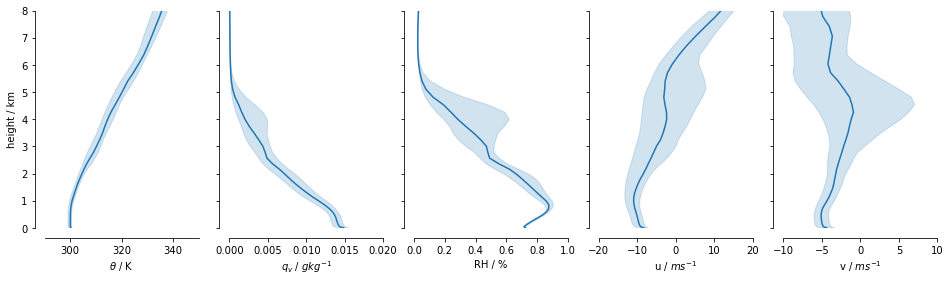

In [1]:
import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)

import xarray as xr
import numpy as np
from function_timer import function_timer 
import boundary_tools as bdt

import matplotlib.pyplot as plt
import plot_utils as pu

@function_timer
def get_quantile_profiles(latbc_path, quantile=0.5):
    def append_quantile_profile(profiles, files, quantile):
        data = xr.open_mfdataset(files)
        profile = data.chunk(dict(time=-1)).quantile(quantile, dim=['time','ncells'])
        profiles.append(profile)
    
    profiles = list()
    for d in [f for f in os.listdir(latbc_path) if not f.endswith('.nc')]:
        path = os.path.join(latbc_path, d)
        files = [os.path.join(path,f) for f in os.listdir(path)]
        append_quantile_profile(profiles, files, quantile)

    return xr.merge(profiles, compat='override')

def augment_profile(profile):
    return bdt.add_relative_humidity(bdt.add_prognostic_variables(profile))

def fetch_quantile(q, data_path='./data', latbc_path='/work/mh1126/m300872/unchanged/latbc'):
    f = f'latbc_q{q*100:.0f}.nc'
    if f in os.listdir(data_path):
        d = xr.open_dataset(os.path.join(data_path, f))
    else:
        d = augment_profile(get_quantile_profiles(latbc_path, quantile=q))
        d.to_netcdf(os.path.join(data_path, f))
    return d

def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

def fetch_quantiles_and_heights(latbc_path='/work/mh1126/m300872/unchanged/latbc'):
    quantile = dict()
    for q in [0.25,0.5,0.75]:
        quantile[q] = fetch_quantile(q, latbc_path=latbc_path)

    z = interpolate_full_level(quantile[0.5]['z_ifc'])/1000
    return quantile, z
    
def fig_boundary_conditions_radtke_like(quantile=False, z=False):
    if not quantile: quantile, z = fetch_quantiles_and_heights()
    
    color = 'tab:blue'
    variables = ['theta_v', 'qv', 'RH', 'u', 'v']
    labels    = ['$\\theta}$ / K', '$q_v$ / $g kg^{-1}$', 'RH / %', 'u / $m s^{-1}$', 'v / $m s^{-1}$']
    xlims     = [(290,350), (0,0.020), (0.0,1), (-20,20), (-10, 10)]
    ylim = (0, 8)

    fig, axs = plt.subplots(1,5, figsize=(16,4))
    for ax, var, label, xlim in zip(axs, variables, labels, xlims):
        ax.fill_betweenx(z, quantile[0.25][var], quantile[0.75][var], alpha=0.2, color=color)
        ax.plot(quantile[0.50][var], z, color=color)
        ax.set_xlabel(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        pu.adjust_spines(ax, ['left', 'bottom'])
        if not ax == axs[0] : ax.set_yticklabels([])
    axs[0].set_ylabel('height / km')
    return fig, axs

fig, axs = fig_boundary_conditions_radtke_like()
img_name = './img/latbc_variance.png'
pu.savefig(fig, img_name)
fig.show()

In [2]:
cold = fetch_quantile(0.5, latbc_path='/work/mh1126/m300872/unchanged/latbc')

h = np.flip(interpolate_full_level(cold['z_ifc'].values))
T_s_0 = cold['temp'].values[-1]
T_min = np.nanmin(cold['temp'].values)
p_surf = cold['pres'].values[-1]
T_increase = 4

p = bdt.hydrostatic_profile(h, p_surf=p_surf)
delta = bdt.joined_profile(p, T_s=T_s_0+T_increase, T_min=T_min) - bdt.joined_profile(p, T_s=T_s_0, T_min=T_min)
delta = np.flip(delta)

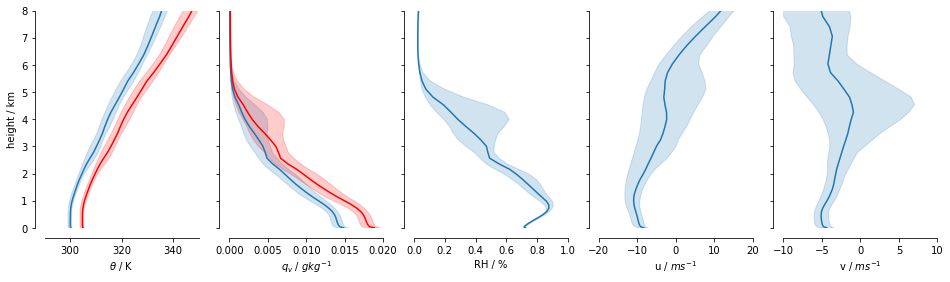

In [3]:
quantiles, z = fetch_quantiles_and_heights()
fig, axs = fig_boundary_conditions_radtke_like(quantiles, z)

for key, value in quantiles.items():
    value = bdt.add_relative_humidity(value)
    value['temp'].values +=  delta
    value = bdt.restore_specific_humidity(value, drop_RH=False)
    value = bdt.add_prognostic_variables(value)
    
var = 'theta_v'; color = 'red'; ax = axs[0]
ax.plot(quantiles[0.5][var], z, color=color)
ax.fill_betweenx(z, quantiles[0.25][var], quantiles[0.75][var], alpha=0.2, color=color)

var = 'qv'; color = 'red'; ax = axs[1]
ax.plot(quantiles[0.5][var], z, color=color)
ax.fill_betweenx(z, quantiles[0.25][var], quantiles[0.75][var], alpha=0.2, color=color)

img_name = './img/latbc_variance_withdelta.svg'
pu.savefig(fig, img_name)
fig.show()

In [4]:
import subprocess as sub
print([os.path.join('./img',f) for f in os.listdir('./img') if 'latbc' in f])
sub.call(['rm',  './img/latbc_variance_withdelta.png'])
print([os.path.join('./img',f) for f in os.listdir('./img') if 'latbc' in f])

['./img/mean_latbc_profiles_11.png', './img/minmax_latbc_profiles_11.png', './img/latbc_variance_withdelta.svg', './img/latbc_variance.png', './img/latbc_variance_withdelta.png']
['./img/mean_latbc_profiles_11.png', './img/minmax_latbc_profiles_11.png', './img/latbc_variance_withdelta.svg', './img/latbc_variance.png']


In [5]:
import os
path = {'ssp245'    : '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp245/r10i1p1f1/',
        'picontrol' : '/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1'}
print(os.listdir(path['picontrol']))

['Eyr', 'Eday', 'LImon', '6hrPlevPt', 'SImon', 'Omon', 'SIday', 'Emon', '3hr', 'EdayZ', 'EmonZ', '6hrPlev', 'Oclim', 'fx', 'Amon', 'Ofx', 'AERmon', 'Lmon', 'CF3hr', 'AERday', 'AERmonZ', 'CFmon', 'Oday', 'CFday', 'E3hr', 'day', 'E3hrPt', '6hrLev', 'Oyr']


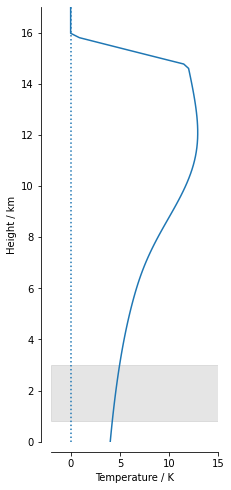

In [10]:
import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)

# import xarray as xr
import numpy as np
# from function_timer import function_timer 
import boundary_tools as bdt
import matplotlib.pyplot as plt
import plot_utils as pu

def plot_monsoon_delta(ax, d1, d2, var, **kwargs):
    p1 = d1[var].values
    p2 = d2[var].values
    h = d1['zg'].values
    plot = ax.plot(p2-p1,h, **kwargs)
    return plot

def plot_adiabat_delta(ax, p_surf, T_s1, T_s2, T_min, **kwargs):
    global ymax
    h = np.linspace(0, ymax, num=100) 
    p = bdt.hydrostatic_profile(h, p_surf)
    t1 = bdt.konrad_moist_adiabat(p,  T_s=T_s1, T_min=T_min)
    t2 = bdt.konrad_moist_adiabat(p,  T_s=T_s2, T_min=T_min)
    # p = hydrostratic_profile(h, p_surf)
    plot = ax.plot(t2-t1, h/1000 , **kwargs)
    return plot

import xarray as xr
cold = xr.open_dataset('../00_preliminary/data/luk100X_control_trades.nc')
warm = xr.open_dataset('../00_preliminary/data/luk102X_ssp585_trades.nc')

ymax = 17000 
l = 8
fig, ax = plt.subplots(figsize=(l*3/8,l))

ax.axvline(0,ls=':')
ax.axhspan(0.800, 3.000, alpha=0.2, color='grey', label='cloud layer')
p_surf = cold['pfull'].values[-1]
T_min = np.nanmin(cold['ta'].values)
# plot_adiabat_delta(ax, p_surf, cold['ta'].values[-1], warm['ta'].values[-1], T_min, label='Moist adiabat')
plot_adiabat_delta(ax, p_surf, cold['ta'].values[-1], cold['ta'].values[-1] + 4, T_min, label="$\\Delta$ moist adiabat")
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Height / km')
# ax.set_title('Moist adiabat')
pu.adjust_spines(ax, ['left','bottom'])
# ax.legend()

xlim = [-2,15]

ax.set_xlim(xlim)
ax.set_ylim([0,ymax/1000])

pu.savefig(fig, './img/deltas_moistadiabat.svg')
fig.show()